# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки:**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**

- Price — цена (евро)

**Для оценки качества моделей применим метрику RMSE.**

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) # реализуем возможность вывода всех столбцов на экран
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
import time

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Видим ряд столбцов, которые не влияют не цену автомобиля - DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen, NumberOfPictures. Месяц регистрации по своему типу похож на год регистрации, но при покупке цена практически не зависит от данного параметра. Т.к. эти столбцы не влияют на цену, то они могут не включаться в модель. Далее речь пойдет только об оставшихся столбцах.
Удалим лишние столбцы (не входят в признаки), чтобы не выводить лишние данные по датасету каждый раз.**

In [5]:
not_features = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures']
df = df.drop(not_features, axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Обработка и заполнение пропусков.

In [6]:
df['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

**Наравне с нормальными типами кузовов, имеются как пропуски, так и просто кузов под названием other. Посмотрим сколько пропусков в типе кузова и как заполнены другие данные для таких строк.**

In [7]:
df[df['VehicleType'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37490 entries, 0 to 354365
Data columns (total 10 columns):
Price               37490 non-null int64
VehicleType         0 non-null object
RegistrationYear    37490 non-null int64
Gearbox             27520 non-null object
Power               37490 non-null int64
Model               30662 non-null object
Kilometer           37490 non-null int64
FuelType            20195 non-null object
Brand               37490 non-null object
NotRepaired         16919 non-null object
dtypes: int64(4), object(6)
memory usage: 3.1+ MB


**Логично будет предположить, что пропуски в типах кузова можно заполнить исходя из модели автомобиля. При этом всего для 30662 объектов указана модель, значит только для них можно выявить тип кузова на основе схожих данных, а остальные данные можно заменить на значение other.**

In [8]:
df['Model'] = df['Model'].fillna('other')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               354369 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [10]:
# Аналогично заполняем VehicleType.
df['VehicleType'] = df['VehicleType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         354369 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               354369 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [11]:
df['Gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

**Видим, что в общем количестве больше всего авто на ручной коробке передач.
Произведем заполнение пропусков также значением "other".**

In [12]:
df['Gearbox'] = df['Gearbox'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         354369 non-null object
RegistrationYear    354369 non-null int64
Gearbox             354369 non-null object
Power               354369 non-null int64
Model               354369 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [13]:
df['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [14]:
# Аналогично коробке произведем заполнение пропусков для типа топлива.
df['FuelType'] = df['FuelType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         354369 non-null object
RegistrationYear    354369 non-null int64
Gearbox             354369 non-null object
Power               354369 non-null int64
Model               354369 non-null object
Kilometer           354369 non-null int64
FuelType            354369 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [15]:
df['NotRepaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

**Видим, что неотремонтированных автомобилей в 7 раза больше, чем ремонтированных. Пропуски в данных скорее всего обусловленны тем, что люди при добавлении объявления на сайт пропускали эту графу, дав понять, что автомобиль не был в ремонте. Опираясь на эти предположения наиболее логичным представляется заполнить пропуски значениями no.**

In [16]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [17]:
df['NotRepaired'].value_counts(dropna=False)

no     318315
yes     36054
Name: NotRepaired, dtype: int64

### Обработка аномальных значений в целевом столбце.

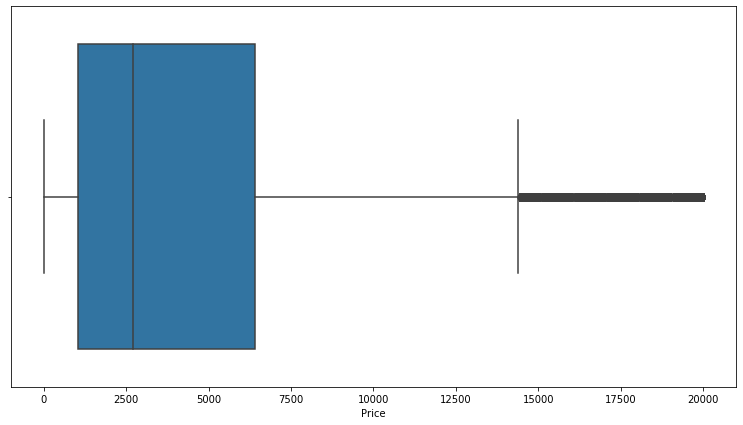

In [18]:
plt.figure(figsize=(13,7))
sns.boxplot(df['Price'])

**Граница правого уса заканчивается на 14500 тысячах евро, далее идут более дорогие машины. Необходимо посмотреть примеры таких машин и определиться являются ли их цены ошибками или они действительно так стоят. Также достаточно большое количество машин стоимостью от 0 до 500 евро. По ним также посмотрим данные более подробно.**

In [19]:
df[df['Price'] < 100]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,other,1990,other,0,corsa,150000,petrol,opel,no
59,1,suv,1994,manual,286,other,150000,other,sonstige_autos,no
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
111,0,other,2017,manual,0,golf,5000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,no
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,no
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


In [20]:
df[df['Price'] == 0]['NotRepaired'].value_counts()

no     8767
yes    2005
Name: NotRepaired, dtype: int64

In [21]:
df[df['Price'] < 100]['NotRepaired'].value_counts()

no     10752
yes     2562
Name: NotRepaired, dtype: int64

**Проанализировав данные по низким ценам можно сделать следующие предположения:**
 - По большей части до 100 евро продаются битые машины.
 - Очень много данных, где цена авто = 0. Скорее всего люди просто хотят избавиться от старого ненужного авто, но возможно, что это ошибка заполнения данных. Так как мы не можем установить истину относительно таких значений, то авто с 0-й ценой лучше исключить из датасета.
 - Если предположить, что машина битая, то она может продаваться за такую цену, но целая машина точно не может стоить меньше хотя бы 100 евро. Поэтому небитые машины с ценой менее 100 евро также исключим из датасета.

**Теперь проанализируем другой конец распределения -  дорогие машины.**

In [22]:
df[df['Price'] > 15000].head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no
33,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
179,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no
204,18400,wagon,2011,auto,313,5er,150000,gasoline,bmw,no
236,15700,sedan,2011,manual,170,golf,90000,gasoline,volkswagen,no
282,18700,coupe,2009,auto,213,mustang,80000,petrol,ford,no
287,16150,suv,2011,manual,150,tiguan,30000,petrol,volkswagen,no
313,16500,coupe,2007,manual,265,z_reihe,150000,petrol,bmw,no


**Судя по данным, в диапазон цен свыше 15000 попали машины действительно дорогого сегмента, поэтому удаление выбросов с этой стороны не требуется.**

In [23]:
df = df[df['Price'] != 0]
df = df.drop(df[(df['Price'] < 100) & (df['NotRepaired'] != 'no')].index)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343040 entries, 0 to 354368
Data columns (total 10 columns):
Price               343040 non-null int64
VehicleType         343040 non-null object
RegistrationYear    343040 non-null int64
Gearbox             343040 non-null object
Power               343040 non-null int64
Model               343040 non-null object
Kilometer           343040 non-null int64
FuelType            343040 non-null object
Brand               343040 non-null object
NotRepaired         343040 non-null object
dtypes: int64(4), object(6)
memory usage: 28.8+ MB


**Также удалим данные с неправдободобными значениями мощности гражданского автомобиля - более 700 л.с., и данные где дата регистрации указана из будущего - что нереально. Таких данных очень мало, поэтому удалим их из датасета, это не повлияет на обучение модели.**

In [25]:
display(df[df['Power'] > 700], df[df['RegistrationYear'] > 2022])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,no
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,no
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,no
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353493,12500,other,2017,manual,2000,other,60000,gasoline,chrysler,no


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
12946,49,other,5000,other,0,golf,5000,other,volkswagen,no
15870,1700,other,3200,other,0,other,5000,other,sonstige_autos,no
17271,700,other,9999,other,0,other,10000,other,opel,no
17346,6500,other,8888,other,0,other,10000,other,sonstige_autos,no
18259,300,other,2200,other,0,twingo,5000,other,renault,no
...,...,...,...,...,...,...,...,...,...,...
326725,60,other,9999,other,0,c4,10000,other,citroen,no
328453,450,other,2500,other,0,6_reihe,5000,other,mazda,no
331753,99,other,9999,other,0,1er,10000,other,bmw,no
334967,12000,other,4000,other,500,golf,5000,other,volkswagen,no


In [26]:
df = df.drop(df[(df['Power'] > 700) & (df['RegistrationYear'] > 2022)].index)

### Проверка на дубликаты

In [27]:
df.duplicated().sum() # проверим на дубликаты

50028

**Видим большое количество дубликатов в датасете, это значит, что продается значительное количество похожих автомобилей. Уберем дубликаты, чтобы не переобучать модели.**

In [28]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293011 entries, 0 to 354368
Data columns (total 10 columns):
Price               293011 non-null int64
VehicleType         293011 non-null object
RegistrationYear    293011 non-null int64
Gearbox             293011 non-null object
Power               293011 non-null int64
Model               293011 non-null object
Kilometer           293011 non-null int64
FuelType            293011 non-null object
Brand               293011 non-null object
NotRepaired         293011 non-null object
dtypes: int64(4), object(6)
memory usage: 24.6+ MB


**Проверим корреляцию признаков между собой.**

In [29]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.030555,0.148075,-0.338483
RegistrationYear,0.030555,1.000000,-0.003386,-0.053217
Power,0.148075,-0.003386,1.000000,0.025811
Kilometer,-0.338483,-0.053217,0.025811,1.000000


**Цена незначительно зависит от года регистрации и мощности авто, обучающие признаки не коррелируют друг с другом, следовательно удаления признаков не требуется.**

### Подготовка датасета для обучения различных моделей.

**Проведем кодирование категориальных признаков. В дальнейшем будем использовать различные модели, в зависимости от модели необходимо применять различные типы кодирования. В случае линейной регрессии подойдет техника прямого кодирования, а в случае деревьев и лесов - порядкового кодирования, поэтому далее будет подготовлено два набора данных для обоих видов кодирования. После кодирования необходимо будет сделать масштабирование числовых признаков. Так как для бустинговых моделей кодировка не требуется, будет подготовлен 3-й датасет без кодировки, но с масштабированием.**

In [30]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# кодирование One-Hot Encoding, OHE
df_ohe = pd.get_dummies(df, drop_first=True, columns=cat_columns)
display(df_ohe.head(10))

# кодирование ordinal encoding, OE
encoder = OrdinalEncoder()
df_oe = df.copy()
df_oe[cat_columns] = encoder.fit_transform(df_oe[cat_columns])
display(df_oe.head(10))

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_other,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_1,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,480,1993,0,150000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,3.0,1993,1.0,0,116.0,150000,6.0,38.0,0.0
1,18300,2.0,2011,1.0,190,166.0,125000,2.0,1.0,1.0
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,0.0
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0
6,2200,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0
8,14500,0.0,2014,1.0,125,60.0,30000,6.0,10.0,0.0
9,999,5.0,1998,1.0,101,116.0,150000,5.0,38.0,0.0
10,2000,4.0,2004,1.0,105,10.0,150000,6.0,19.0,0.0


In [31]:
# функция для деления датасетов на обучающую, и тестовую выборки
def split_func (df):
    target = df['Price']
    features = df.drop('Price', axis=1)
    features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) 
    return features_train, features_test, target_train, target_test

In [32]:
# получим выборки для кодировки ohe
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = split_func(df_ohe)

In [33]:
# получим выборки для кодировки oe
features_train_oe, features_test_oe, target_train_oe, target_test_oe = split_func(df_oe)

In [34]:
# получим выборки без кодировки
features_train_no, features_test_no, target_train_no, target_test_no = split_func(df)

In [35]:
# подготовим функцию для масштабирования
def scal_func (features_train, features_test):
    numeric = ['RegistrationYear', 'Power', 'Kilometer']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    return features_train, features_test

In [36]:
# масштабируем данные с кодировкой ohe
features_train_ohe, features_test_ohe = scal_func(features_train_ohe, features_test_ohe)

In [37]:
# масштабируем данные с кодировкой oe
features_train_oe, features_test_oe = scal_func(features_train_oe, features_test_oe)

In [38]:
# масштабируем данные без кодировки
features_train_no, features_test_no = scal_func (features_train_no, features_test_no)

**ВЫВОД**

 - Удалены столбцы, не являющиеся обучающими признаками (DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen, NumberOfPictures).
 - Проведено заполнение пропусков значением other для: типа кузова, типа коробки передач, типа топлива, состояния ремонта.
 - Исключены нулевые цены, а также цены до 100 евро на небитые автомобили.
 - Удалены дубликаты.
 - Проведена проверка на мультиколлинеарность.
 - Датасет разделен на обучающие, валидационные и тестовые выборки для трех кодировок: one-hot encoding, ordinal encoding, без кодировки.
 - Проведено масштабирование количественных данных.

## Обучение моделей (я закомментил все обучения моделей, так как очень много времени занимает, чтобы не ждать каждый раз при загрузке блокнота)

**Обучим следующие модели: линейная регрессия, дерево решений, случайный лес, LightGBM.**

### Линейная регрессия.

In [39]:
# создадим функцию для необходимого скора
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

In [40]:
# Произведем определение оптимальных параметров для линейной регрессии с помощью GridSearchCV.
'''model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
grid.fit(features_train_ohe, target_train_ohe)
print("RMSE линейной регрессии составляет ", grid.best_score_)
print('Наилучшие подобранные параметры для линейной регрессии', grid.best_params_)'''

'model = LinearRegression()\nparameters = {\'fit_intercept\':[True,False], \'normalize\':[True,False]}\ngrid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)\ngrid.fit(features_train_ohe, target_train_ohe)\nprint("RMSE линейной регрессии составляет ", grid.best_score_)\nprint(\'Наилучшие подобранные параметры для линейной регрессии\', grid.best_params_)'

**Наилучший RMSE 3241.883 при GridSearchCV получен для параметров: 'fit_intercept': True, 'normalize': False.**

### Дерево решений

In [41]:
'''tree = DecisionTreeRegressor(random_state=12345)  
tree_params = {'max_depth': range(1,15), 'min_samples_split': range(2,7)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, verbose=5, scoring=scorer)
tree_grid.fit(features_train_oe, target_train_oe)
print("RMSE для решающего дерева составляет ", tree_grid.best_score_)
print('Наилучшие подобранные параметры для решающего дерева')
print(tree_grid.best_params_)'''

'tree = DecisionTreeRegressor(random_state=12345)  \ntree_params = {\'max_depth\': range(1,15), \'min_samples_split\': range(2,7)}\ntree_grid = GridSearchCV(tree, tree_params, cv=5, verbose=5, scoring=scorer)\ntree_grid.fit(features_train_oe, target_train_oe)\nprint("RMSE для решающего дерева составляет ", tree_grid.best_score_)\nprint(\'Наилучшие подобранные параметры для решающего дерева\')\nprint(tree_grid.best_params_)'

**Наилучший RMSE 2027.92 при GridSearchCV получен для параметров: 'max_depth': 14, 'min_samples_split': 6.**

### Случайный лес.

In [42]:
'''forest = RandomForestRegressor(random_state=12345)   
forest_params = {'n_estimators': range(30, 81, 10),'max_depth': range(1,12)}
forest_grid = GridSearchCV(forest, forest_params,cv=5, verbose=5, scoring=scorer)                       
forest_grid.fit(features_train_oe, target_train_oe)
print("RMSE для случайного леса составляет ", forest_grid.best_score_)
print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)'''

'forest = RandomForestRegressor(random_state=12345)   \nforest_params = {\'n_estimators\': range(30, 81, 10),\'max_depth\': range(1,12)}\nforest_grid = GridSearchCV(forest, forest_params,cv=5, verbose=5, scoring=scorer)                       \nforest_grid.fit(features_train_oe, target_train_oe)\nprint("RMSE для случайного леса составляет ", forest_grid.best_score_)\nprint(\'Наилучшие подобранные параметры для случайного леса\')\nprint(forest_grid.best_params_)'

**Наилучший RMSE 1939.527 при GridSearchCV для случайного леса получен для параметров: 'max_depth': 11, 'n_estimators': 70.**

### Light GBM

**Так как библиотека Light GBM требует закодированные целыми числами категориальные признаки, такие признаки переведем в тип category.**

In [43]:
def obj_to_cat (df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')

In [44]:
obj_to_cat(features_train_no)
features_train_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234408 entries, 311771 to 254036
Data columns (total 9 columns):
VehicleType         234408 non-null category
RegistrationYear    234408 non-null float64
Gearbox             234408 non-null category
Power               234408 non-null float64
Model               234408 non-null category
Kilometer           234408 non-null float64
FuelType            234408 non-null category
Brand               234408 non-null category
NotRepaired         234408 non-null category
dtypes: category(6), float64(3)
memory usage: 8.7 MB


In [45]:
'''gbm = LGBMRegressor(random_state=12345)   
g_params = {'n_estimators': [50, 100, 500],'num_leaves': [21, 31, 41],'learning_rate':[0.01, .04, 0.06]}
g_grid = GridSearchCV(gbm, g_params,cv=5, verbose=5, scoring=scorer)
g_grid.fit(features_train_no, target_train_no)
print("RMSE для LGBM составляет ", g_grid.best_score_)
print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)'''

'gbm = LGBMRegressor(random_state=12345)   \ng_params = {\'n_estimators\': [50, 100, 500],\'num_leaves\': [21, 31, 41],\'learning_rate\':[0.01, .04, 0.06]}\ng_grid = GridSearchCV(gbm, g_params,cv=5, verbose=5, scoring=scorer)\ng_grid.fit(features_train_no, target_train_no)\nprint("RMSE для LGBM составляет ", g_grid.best_score_)\nprint(\'Наилучшие подобранные параметры для LGBM\')\nprint(g_grid.best_params_)'

**Наилучший RMSE 1684.875 при GridSearchCV для LGBM получен для параметров: 'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41.**

**ВЫВОД** 

 - Обучено и подобраны гиперпараметры для 4 различных моделей: линейная регрессия, дерево решений, случайный лес, LightGBM. Для всех моделей была применена кросс-валидация, вставленная в метод GridSearchCV.

 - Наихудшим результатом (3241) обладает модель линейной регрессии, наилучший результат был получен с помощью модели Light GBM (1684.).
 - В следующем разделе каждая модель с найденными гиперпараметрами будет обучена на трейне и протестирована на тестовой выборке.

## Анализ моделей

### Линейная регрессия

In [46]:
model = LinearRegression(fit_intercept=True, normalize=False)
start_fit_time = time.time()
model.fit(features_train_ohe, target_train_ohe)
stop_fit_time = time.time()
fit_time = stop_fit_time - start_fit_time
start_predict_time = time.time()
predictions = model.predict(features_test_ohe)
stop_predict_time = time.time()
pred_time = stop_predict_time - start_predict_time
rmse = mean_squared_error(target_test_ohe, predictions)**0.5
print("RMSE линейной регрессии составляет", rmse)
print("Время обучения модели LinearRegression составляет", fit_time)
print("Скорость предсказания модели LinearRegression составляет", pred_time)

RMSE линейной регрессии составляет 3239.682599208238
Время обучения модели LinearRegression составляет 22.73581862449646
Скорость предсказания модели LinearRegression составляет 0.1964428424835205


### Дерево решений

In [47]:
model = DecisionTreeRegressor(max_depth=14, min_samples_split=6, random_state=12345)
start_fit_time = time.time()
model.fit(features_train_oe, target_train_oe)
stop_fit_time = time.time()
fit_time = stop_fit_time - start_fit_time
start_predict_time = time.time()
predictions = model.predict(features_test_oe)
stop_predict_time = time.time()
pred_time = stop_predict_time - start_predict_time
rmse = mean_squared_error(target_test_oe, predictions)**0.5
print("RMSE дерева решений составляет", rmse)
print("Время обучения модели DecisionTreeRegressor составляет", fit_time)
print("Скорость предсказания модели DecisionTreeRegressor составляет", pred_time)

RMSE дерева решений составляет 2014.3474567893813
Время обучения модели DecisionTreeRegressor составляет 0.7267382144927979
Скорость предсказания модели DecisionTreeRegressor составляет 0.012237071990966797


### Случайный лес

In [48]:
model = RandomForestRegressor(max_depth=11, n_estimators=70, random_state=12345)
start_fit_time = time.time()
model.fit(features_train_oe, target_train_oe)
stop_fit_time = time.time()
fit_time = stop_fit_time - start_fit_time
start_predict_time = time.time()
predictions = model.predict(features_test_oe)
stop_predict_time = time.time()
pred_time = stop_predict_time - start_predict_time
rmse = mean_squared_error(target_test_oe, predictions)**0.5
print("RMSE случайного леса составляет", rmse)
print("Время обучения модели RandomForestRegressor составляет", fit_time)
print("Скорость предсказания модели RandomForestRegressor составляет", pred_time)

RMSE случайного леса составляет 1936.5127179567296
Время обучения модели RandomForestRegressor составляет 24.59758734703064
Скорость предсказания модели RandomForestRegressor составляет 0.3767054080963135


### Light GBM

In [49]:
obj_to_cat(features_test_no) # переводим признаки в тип category.
model = LGBMRegressor(learning_rate=0.06, n_estimators=500, num_leaves=41, random_state=12345)
start_fit_time = time.time()
model.fit(features_train_no, target_train_no)
stop_fit_time = time.time()
fit_time = stop_fit_time - start_fit_time
start_predict_time = time.time()
predictions = model.predict(features_test_no)
stop_predict_time = time.time()
pred_time = stop_predict_time - start_predict_time
rmse = mean_squared_error(target_test_no, predictions)**0.5
print("RMSE градиентного бустинга составляет", rmse)
print("Время обучения модели LGBMRegressor составляет", fit_time)
print("Скорость предсказания модели LGBMRegressor составляет", pred_time)

RMSE градиентного бустинга составляет 1689.6987543832563
Время обучения модели LGBMRegressor составляет 40.34284520149231
Скорость предсказания модели LGBMRegressor составляет 2.8148927688598633


**ВЫВОД**

Проведенный анализ с проверкой моделей на тестовой выборке показал, что наилучшую метрику RMSE возможно получить с применением библиотеки Light GBM. Если сравнить суммарное время на fit_predict, то модель LGBMRegressor выполнила поставленную задачу медленнее остальных моделей.
Проведенное тестирование показало, что бустинговая модель даёт значительно лучший скор, чем линейная регрессия, дерево решений и случайный лес.